In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Qiskit関連のパッケージをインポート
from qiskit import IBMQ, Aer,assemble,transpile, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import MCMT

In [2]:
def initialize_s(qc, qubits):
    # 回路のqubitsにHゲートを適用
    for q in qubits:
        qc.h(q)

    return qc

In [3]:
def oracle(qubits):
    # オラクルを作成して、回路に実装
    oracle = QuantumCircuit(n)

    # マルチ制御Zゲートをかけます
    oracle.h(qubits-1)
    oracle.mct(list(range(qubits-1)), qubits-1)  # マルチ制御トフォリ
    oracle.h(qubits-1)
    
    oracle.draw()
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "oracle"
    
    return oracle_gate

In [4]:
# オラクル
qc = QuantumCircuit(3)
qc.h(2)
qc.mct([0,1], 2)  # マルチ制御トフォリ
qc.h(2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "oracle"
qc.draw()

q_0: ───────■───────
            │       
q_1: ───────■───────
     ┌───┐┌─┴─┐┌───┐
q_2: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘

In [5]:
def diffuser(n):
    qc = QuantumCircuit(n)

    # Hゲートで |s> -> |00..0> に変換
    for qubit in range(n):
        qc.h(qubit)
    # Xゲートで |00..0> -> |11..1> に変換
    for qubit in range(n):
        qc.x(qubit)
    # マルチ制御Zゲートをかけます
    qc.h(n - 1)
    qc.mct(list(range(n - 1)), n - 1)  # マルチ制御トフォリ
    qc.h(n - 1)
    # |11..1> -> |00..0> に変換
    for qubit in range(n):
        qc.x(qubit)
    # |00..0> -> |s> に変換
    for qubit in range(n):
        qc.h(qubit)

    U_s = qc.to_gate()
    U_s.name = "diffuser"
    
    return U_s

In [6]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, list(range(n)))
# grover_circuit.append(oracle(n), list(range(n)))
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), list(range(n)))
# grover_circuit.append(oracle(n), list(range(n)))
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), list(range(n)))
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├─░─┤M├──────
        ├───┤│         ││           ││         ││           │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 oracle ├┤1 diffuser ├┤1 oracle ├┤1 diffuser ├─░──╫─┤M├───
        ├───┤│         ││           ││         ││           │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├─░──╫──╫─┤M├
        └───┘└─────────┘└───────────┘└─────────┘└───────────┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════════════════════════════╩══╩══╩═
                                                                 0  1  2

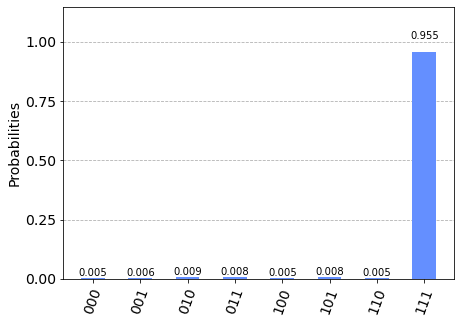

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)